# MiniWoB intro


Mini World of Bits (MiniWoB) is an RL benchmark introduced by OpenAI researchers in 2017.

Their original paper http://proceedings.mlr.press/v70/shi17a/shi17a.pdf

The core idea is to create a set of browser-based tasks to be solved using RL methods. Every task is a small dynamic webpage, which could be interacted using a mouse or keyboard. The reward is given for executing correct sequence of actions. Description of the goal is included into the webpage.

In total it introduced 80 problems of varying complexity -- from the trivial like clicking the form button to very challenging, for example booking the flight following the criterias.

The problems are available here: https://stanfordnlp.github.io/miniwob-plusplus/

Unfortunately, OpenAI discontinued MiniWoB project, so, it hasn't gained popularity it deserves. After OpenAI paper in 2017, MiniWoB was used in several research papers, the most notable ones:

* [1802.08802 Reinforcement Learning on Web Interfaces Using Workflow-Guided Exploration](https://arxiv.org/abs/1802.08802)
* [1812.09195 Learning to Navigate the Web](https://arxiv.org/abs/1812.09195v1)
* [1902.07257v1 DOM-Q-NET: Grounded RL on Structured Language](https://arxiv.org/abs/1902.07257v1)

But that's almost nothing in comparison to Atari games popularity. To fix this mistake, let's play with MiniWoB in this tutorial.

This tutorial uses the original MiniWoB. There exists the imroved version from Stanford researches, called [MiniWoB++](https://stanfordnlp.github.io/miniwob-plusplus/)


## Why that's still relevant for RL

You might ask, why do we need to play with two discontinued projects published two years ago (almost eternity by ML/DL field pace). There are several reasons for that:

* MiniWoB problems are still very far from being solved. 
* Some of them are much harder and much close to real-life human behaviour than Atari games. 
* MiniWoB has practical application in automated software testing, web data extraction and automation.
* Universe with all its issues, allows fast integration of applications into RL experiments without modifying the source code.
* The most important: it's fun!

## Architecture

MiniWoB is implemented as a part of [OpenAI Universe](https://github.com/openai/universe) (another frozen project of OpenAI). The idea of Universe is to use VNC protocol to connect RL agent with GUI applications. As VNC is a cross-platform protocol used by humans to communicate with remote GUI applications, RL agent also achieves this ability (is RL agent smart enough to communicate is a different question). 

MiniWoB is a part of Universe, where GUI app is a browser with loaded dynamic webpages.

Overall architecture of Universe is shown below

![Arch](images/arch.png)

The original MiniWoB docker image is available [on quay.io](https://quay.io/repository/openai/universe.world-of-bits), but I suggest you to use my version with fixed stability issues. The fixed version is available [on dockerhub](https://cloud.docker.com/u/shmuma/repository/docker/shmuma/miniwob). If you want to build your own version of the fixed image, you can follow [instructions here](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/tree/master/Chapter13/wob_fixes)


## Starting the container

If you have docker installed, you can start the single container running the following command:

`docker run -d -p 5900:5900 -p 15900:15900 --privileged --ipc host --cap-add SYS_ADMIN shmuma/miniwob run`

Here, the options:
* `-d` detaches container from terminal and keeps it running in background
* `-p 5900:5900` forwards VNC port to the host machine
* `-p 15900:15900` forwards rewarder port 
* `--privileged` gives extended privileges to this container (not sure is this needed or not, that was written in OpenAI manual)
* `--ipc host` uses host's IPC namespace
* `--cap-add SYS_ADMIN` extends container privileges
* `shmuma/miniwob` name of the container image to start, you can use `quay.io/openai/universe.world-of- bits:0.20.0` to start original MiniWoB image
* `run` command to start inside container

During the training, several containers could be started (to decrease training samples correlation), to simplify this process, this repo includes two scripts: `containers_run.sh` and `containers_stop.sh`. The first starts the required amount of containers (given in command line), the second script stops all started containers (be careful, it just stops ALL containers, not only started by `containers_run.sh` script).

In [1]:
!cat containers_run.sh

#!/usr/bin/env bash
IMAGE_NAME=shmuma/miniwob

count=`docker ps -q | wc -l`

if test $count -ne 0 ; then
    echo You already have $count containers running, are you sure you want more?
    exit
fi

for i in `seq 1 ${1:-1}`; do
    echo Starting container $i
    P1=$((5900+$i-1))
    P2=$((15900+$i-1))
    docker run -d -p $P1:5900 -p $P2:15900 --privileged --ipc host --cap-add SYS_ADMIN $IMAGE_NAME run
done


In [2]:
!cat containers_stop.sh

#!/usr/bin/env bash

docker stop `docker ps -q`


In [4]:
!./containers_run.sh 1

Starting container 1
af325a2823471cf62f88a0f8a750da09b283faaf698a66de5befff5bd6e66884


In [6]:
!docker ps

CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS              PORTS                                                        NAMES
af325a282347        shmuma/miniwob      "/app/universe-envs/…"   20 seconds ago      Up 19 seconds       0.0.0.0:5900->5900/tcp, 5899/tcp, 0.0.0.0:15900->15900/tcp   quirky_elgamal


After this you can connect to the started container using one of many VNC clients available. If you're using MacOS, VNC client is already included in OS, in Finder press `Command+K` and then connect to 'vnc://localhost:5900'. Password for connection is `openai`

![](images/vnc.png)

Do not forget to stop containers, as they are quite CPU-hungry 

In [7]:
!./containers_stop.sh

af325a282347


# Imports

In [11]:
import gym
import time
import universe

from PIL import Image

/anaconda3/envs/miniwob/lib/python3.6/site-packages/universe/runtimes/__init__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  spec = yaml.load(f)


In [13]:
DOCKER_IMAGE = "shmuma/miniwob:latest"

In [10]:
# function to build connection endpoints for set of containers
def remotes_url(port_ofs=0, hostname='localhost', count=8):
    hosts = ["%s:%d+%d" % (hostname, 5900 + ofs, 15900 + ofs) for ofs in range(port_ofs, port_ofs+count)]
    return "vnc://" + ",".join(hosts)

## Gym actions/observations

### Universe vectorized observations/actions

Before we start looking at actual MiniWoB action and observation spaces, we need to state one quite important difference between OpenAI Gym and OpenAI Universe. 

Gym API is **synchronous** in terms of agent's calls to `step()` function and internal environment state. For example, if the agent playing Atari decided to download the 10GB model file (between calls to `step()`), Atari 2600 emulator and the game it emulates notice nothing, as Atari knows nothing about wall clock time, only about ticks of 6507 MCU and internal emulated hardware state. Gym can do this, because it has the full control over every environment it exposes to the developer.

In contrast, Universe has much less knowledge and control over the software it communicates with. VNC protocol provides remote framebuffer interface (low-level name of VNC protocol is RFB), capturing the image on the remote machine and transferring it to VNC client running in front of you. Your actions, like mouse movements and key presses are recorded and being sent to the VNC server. So, VNC is relatively thin protocol providing the impression that remote applications are running locally. This simplifies application integration, but at the same time if you've missed same frame from the input images stream, you've missed it. So, Universe Gym API is **asynchronous**:

* agent needs to be fast enough to process observations and keep the desired framerate. This might be important in cases when something qick is happening on the screen
* on `reset()` call, environment takes some time to start producing observations. To indicate this transient states, it returns None for observations, which means you need to wait and repeat the request.

Another difference is in native support of several environments running in parallel. On creation of environment you can specify how many of them need to be created and system will start several docker images running in parallel. Alternatively, you can provide several ports of already running docker images (possibly on remote machines in the cloud). As a result, Universe `Env` instance returns vectors of observations from `reset()` and `step()` calls and expects you to provide vector of actions for `step()`. This breaks the API, but simplifies the development. 

Ptan library supports both vectorized and old-style environments, which also makes your life a little bit easier. 

### Observations and actions

Universe exposes two new subclasses of Gym `Space` class: [`VNCActionSpace`](https://github.com/openai/universe/blob/master/universe/spaces/vnc_action_space.py) and `VNCObservationSpace`

Action space is a container for `VNCKeyEvent` or `VNCPointerEvent`: https://github.com/openai/universe/blob/master/universe/spaces/vnc_event.py

Observation from single environment is a dictionary with two keys: `vision` with image pixels and `text` with text description from the environment.

In [8]:
!./containers_run.sh 1

Starting container 1
bcff2889871a23777911f39573457abd0f94ba06f7e8356dd78b7215b348c4d2


In [14]:
env = gym.make("wob.mini.ClickDialog-v0")
url = remotes_url(count=1)
print(url)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=5, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-06-26 08:58:03,501] Making new env: wob.mini.ClickDialog-v0
[2019-06-26 08:58:03,506] Writing logs to file: /tmp/universe-11132.log
[2019-06-26 08:58:03,512] Using the golang VNC implementation
[2019-06-26 08:58:03,514] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-26 08:58:03,525] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai


vnc://localhost:5900+15900


[2019-06-26 08:58:03,743] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-26 08:58:04,601] [0:localhost:5900] Initial reset complete: episode_id=14


In [16]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    print("Env is still resetting...")
    time.sleep(1)

[2019-06-26 08:58:54,862] Throttle fell behind by 51.13s; lost 255.66 frames


Env is still resetting...


We've got the first observation. The result is a list of single dict (remember vectorized form of universe observations?) 

In [17]:
obs

[{'vision': array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  'text': [{'instruction': 'Close the dialog box by clicking the "x".'}]}]

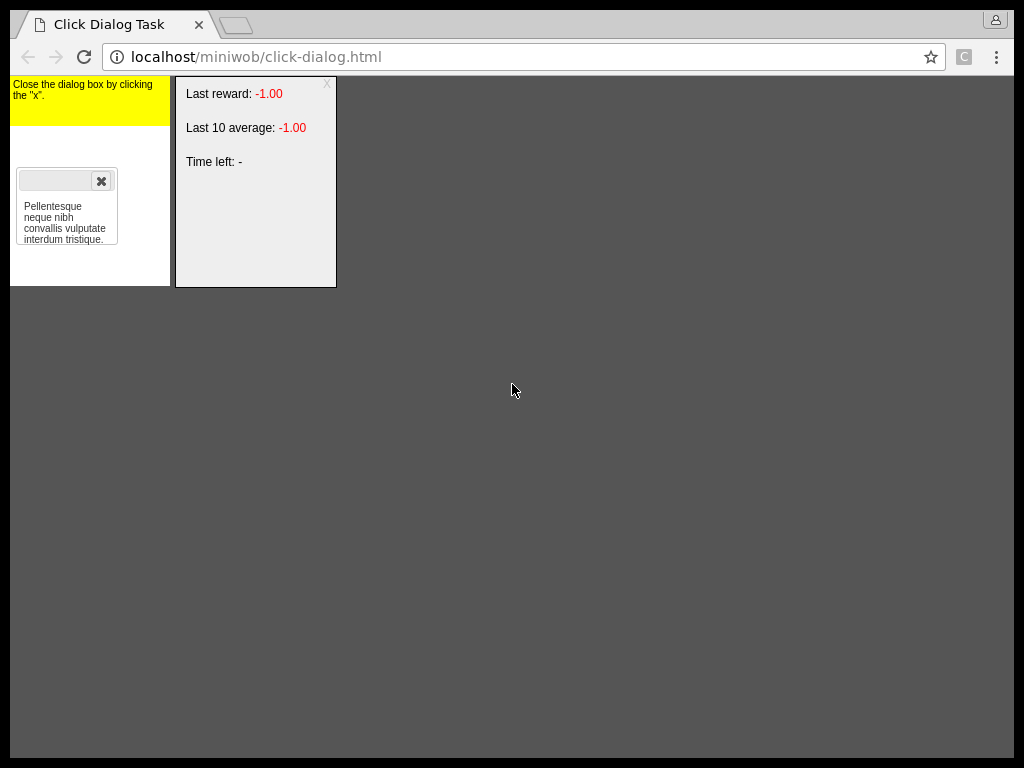

In [18]:
im = Image.fromarray(obs[0]['vision'])
im

As you can see, image is not cropped which is not very convenient

In [19]:
!./containers_stop.sh

bcff2889871a
